In [510]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline
import numpy as np
from datetime import datetime, timedelta
import urllib.request
import pandas as pd

def coloravg(c1,c2):
    rgb0 = mcolors.colorConverter.to_rgb(c1)
    rgb1 = mcolors.colorConverter.to_rgb(c2)
    rgb = [np.sqrt((rgb0[i]**2 + rgb1[i]**2)/2) for i in range(3)]
    return rgb

LEVELS = {
    "0.0": {"name":"V-B/0", "colors":["#db67cc","#db67cc"]},
    "0.5": {"name":"V-0/1", "colors":["#db67cc","#FFFB4F"]},
    "1.5": {"name":"V-1/2", "colors":["#FFFB4F","#FFFB4F"]},
    "2.5": {"name":"V-2/3", "colors":["#FFFB4F","#64A25A"]},
    "3.5": {"name":"V-3/4", "colors":["#64A25A","#64A25A"]},
    "4.5": {"name":"V-4/5", "colors":["#64A25A","#FFA135"]},
    "5.5": {"name":"V-5/6", "colors":["#FFA135","#FFA135"]},
    "6.5": {"name":"V-6/7", "colors":["#FFA135","#008BEE"]},
    "7.5": {"name":"V-7/8", "colors":["#008BEE","#008BEE"]},
    "8.5": {"name":"V-8/9", "colors":["#008BEE","#dddddd"]},
    "9.5": {"name":"V-9+", "colors":["#dddddd","#dddddd"]},
}

def dfdates2datetimes(dates):
    return [datetime.strptime(str(d[0]).replace('T00:00:00.000000000',''), "%Y-%m-%d") for d in dates]
    
def level_to_color(level):
    return coloravg(*LEVELS[str(level)]["colors"])

def level_to_label(level):
    return LEVELS[str(level)]["name"]  

def vector_level_to_color(levels):
    return [level_to_color(l) for l in levels]


def label_grades(ax):
    for level in LEVELS.keys():
        ax.text(x=0.02, 
                y=(float(level)+0.5)/10.5, 
                s=LEVELS[level]["name"],
                size=20, 
                va='top' if level=="0.0" else 'center', 
                color='black' if level in ['1.5',"2.5"] else 'white', 
                alpha=0.1, 
                transform=ax.transAxes)

def grade_colour_bars(ax):
    ls_ = reversed(list(LEVELS.keys()))
    is_ = reversed(list(range(len(list(LEVELS.keys())))))

    for l, i in zip(ls_, is_):
        if i == 0:
            lower = float(l)-0.5
            upper = 0
        else:
            lower = float(l)-0.5
            upper = float(l)+0.5
        ax.axhspan(lower, upper, color=coloravg(*LEVELS[str(l)]["colors"]))
    label_grades(ax)
        
    ax.set_ylabel("Grade")
    ax.set_yticks([float(l) for l in LEVELS.keys()])
    ax.set_yticklabels(["" for l in LEVELS.keys()])

In [511]:
def plot_cum_frac(df, attempt=0):
    levels = sorted(df[df['attempt']==attempt]['level'].unique())
    dates = sorted(df[df['attempt']==attempt]['date'].unique())
    totals_by_level = df[df['attempt']==attempt].pivot_table(index='date', columns='level',values='count',aggfunc='sum',fill_value=0).to_numpy()
    totals_by_date = df[df['attempt']==attempt].groupby('date').sum()['count'].to_numpy()

    frac_by_level = (totals_by_level.T/totals_by_date)
    cum_by_level = np.cumsum(frac_by_level, axis=0)

    fig, ax = plt.subplots(1,1,figsize=(14,6))

    for i, l in enumerate(levels):
        #ax.plot(dates, frac_by_level[i,:], color=coloravg(*LEVELS[str(L)]["colors"]))


        if i==0:
            ax.fill_between(dates,
                            cum_by_level[i,:],
                            np.zeros_like(cum_by_level[i,:]),
                            color=coloravg(*LEVELS[str(l)]["colors"]),
                            label=LEVELS[str(l)]['name'],
                             )
        else:
            ax.fill_between(dates,
                            cum_by_level[i,:],
                            cum_by_level[i-1,:], 
                            color=coloravg(*LEVELS[str(l)]["colors"]),
                            label=LEVELS[str(l)]['name'],
                           )
    ax.set_xlim([min(dates), max(dates)])
    ax.set_ylim([0,1])
    if attempt==0:
        label="successful"
    else:
        label="attempted"
    ax.set_title(f"Fraction {label} climbs by level")

    fig.show()
    
def climbing_score(df):
    df['score'] = df.apply(lambda row: row['level']*row['count'] if row['attempt']==1 else 2.0*row['level']*row['count'] + 4.0*row['flash'], axis=1)
    dates = df['date'].unique()
    scores = df.groupby('date').sum()['score']

    fig, ax = plt.subplots(1,1,figsize=(14,6))
    ax.set_ylabel("Score")
    ax.plot(dates, scores, 'ko-')

    ax.set_xlabel("Date")
    ax.set_title("Climbing score, S")
    ax.text(0.95,0.95,"$S=4\sum g_\mathrm{flash} + 2\sum g_\mathrm{complete} +  \sum g_\mathrm{attempt} $", va='top', ha='right', transform=ax.transAxes, size=20)

In [512]:
def climbing_trends(df):
    dates = dfdates2datetimes(df[df['attempt']==0].groupby(['date'])['date'].unique())

    S_mean = df[df['attempt']==0].groupby(['date']).mean()['level']
    S_std = df[df['attempt']==0].groupby(['date']).std()['level']

    A_mean = df[df['attempt']==1].groupby(['date']).mean()['level']
    A_std = df[df['attempt']==1].groupby(['date']).std()['level']


    fig, ax = plt.subplots(1,1,figsize=(14,6))
    ax.errorbar(dates, S_mean, yerr=S_std, color='k', marker='o', label='Completed')
    ax.errorbar(dates, A_mean, yerr=A_std, color='#FF4444', marker='x', alpha=1.0, label='Attempts')


    F = df[df['flash']==1].groupby(['date']).sum()['level'] / df[df['flash']==1].groupby(['date']).sum()['flash']
    flashdates = F.keys()
    flashlevels = np.array(F)


    ax.plot(flashdates, flashlevels, 'o--', color='yellow', markeredgecolor='k', zorder=5, label='Flashed')


        
    ax.set_xlim([dates[0] -timedelta(days=1), dates[-1] + timedelta(days=1)])

    ax.set_ylim([-0.5,10])
    grade_colour_bars(ax)
    ax.legend()
    fig.show()    

def scatterplotclimbs(df, attempt=0):
    
    
    fig, ax = plt.subplots(1,1,figsize=(14,6))
    
    dat = df[df['attempt']==attempt]
    dates = dat['date']
    
    
    mean = df[df['attempt']==attempt].groupby(['date']).mean()['level']
    std = df[df['attempt']==attempt].groupby(['date']).std()['level']
    udates = dat['date'].unique()
    
    
    
    numpoints = dat['level'].shape[0]
    
    rs = np.tile(np.linspace(0,1.0,num=10), numpoints//10+1)-0.5
    rs=rs[0:numpoints]
    #r = np.random.rand(numpoints)-0.5
    r=rs
    
    uniquedates = dates.unique()
    uniquelevels = dat['level'].unique()
    
    yoffsets = [0,]
    rs = np.linspace(-0.5,0.5,num=10)
    np.random.shuffle(rs)
    for i in rs:
        yoffsets.append(i)
    
    
    toffsets = [timedelta(hours=0)]
    rs = np.linspace(-12,12,num=10)
    np.random.shuffle(rs)
    for i in rs:
        toffsets.append(timedelta(hours=i))
    
    for date in uniquedates:
        for level in uniquelevels:
            i = -1
            result = df[(df['attempt']==attempt) &
                            (df['date']==date) & 
                            (df['level']==level)]           
            for idx, point in result.iterrows():
                i += 1
                ax.scatter(x=point['date']+toffsets[i%len(toffsets)], y=point['level']+yoffsets[i%len(yoffsets)], marker='D',s=100,edgecolor='k',
                           zorder=1000-i, color=vector_level_to_color([point['level']]))
    ax.set_ylim([-0.5, 10])
    grade_colour_bars(ax)
    ax.set_xlim([uniquedates.min()-np.timedelta64(1,'D'),uniquedates.max()+np.timedelta64(1, 'D')])
    return fig,ax


In [519]:
def success_ratio(df):

    alllevels = sorted(df['level'].unique())
    alldates = sorted(df['date'].unique())
    allattempts = [0,1]

    alldata = np.zeros((len(alldates), len(alllevels), len(allattempts)))

    for _id, date in enumerate(alldates):
        for _il, level in enumerate(alllevels):
            for _ia, attempt in enumerate(allattempts):
                data = df[(df['date']==date) & (df['level']==level) & (df['attempt']==attempt)]['count'].to_numpy()
                if len(data)>0:
                    alldata[_id,_il,_ia] = data[0]


    ratio = alldata[:,:,0] / (alldata[:,:,0] + alldata[:,:,1])

    ratioDF = pd.DataFrame(data=ratio)
    ratioDF = ratioDF.replace({0:np.nan})

    interpolated = ratioDF.interpolate(axis=0).to_numpy()

    fig, ax = plt.subplots(1,1,figsize=(14,len(alllevels)))

    ticks = []
    ticklabels = []
    for _il, level in enumerate(alllevels):
        ax.fill_between(x=alldates, y1=interpolated[:,_il]+_il, y2=np.zeros_like(ratio[:,_il]) + _il, color=level_to_color(level))
        ax.axhline(y=_il, linestyle='-', color='k', linewidth=0.75, alpha=0.5)
        ax.axhline(y=_il+0.25, linestyle='--', color='k', linewidth=0.5, alpha=0.2)
        ax.axhline(y=_il+0.5, linestyle='--', color='k', linewidth=0.5, alpha=0.2)
        ax.axhline(y=_il+0.75, linestyle='--', color='k', linewidth=0.5, alpha=0.2)
        ticks.append(_il)
        ticklabels.append("")
        ticks.append(_il + 0.5)
        ticklabels.append(level_to_label(level))


    ax.set_ylim([0, max(alllevels) + 1.5])
    ax.set_xlim([min(alldates), max(alldates)])
    ax.set_yticks(ticks)
    ax.set_yticklabels(ticklabels)
    ax.set_title("Success ratio by grade over time\n completions / (attempts + completions)\nzeros interpolated after first success in level ")
    fig.show()

/home/kmills/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/home/kmills/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/kmills/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


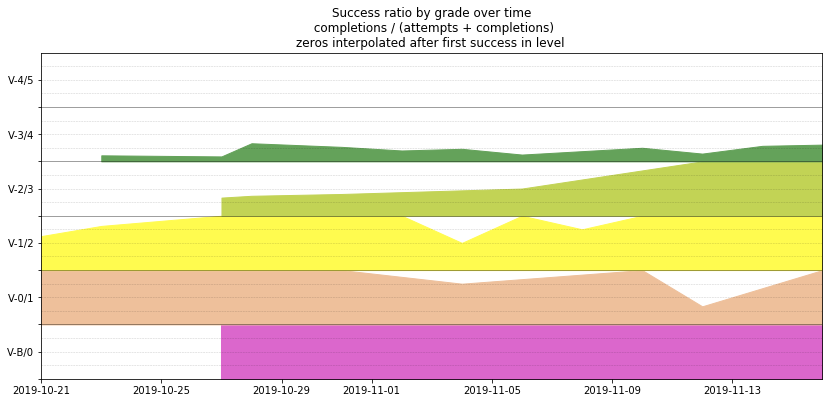

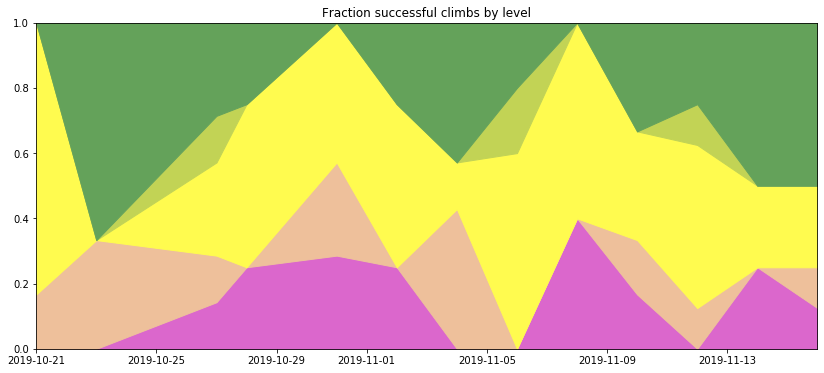

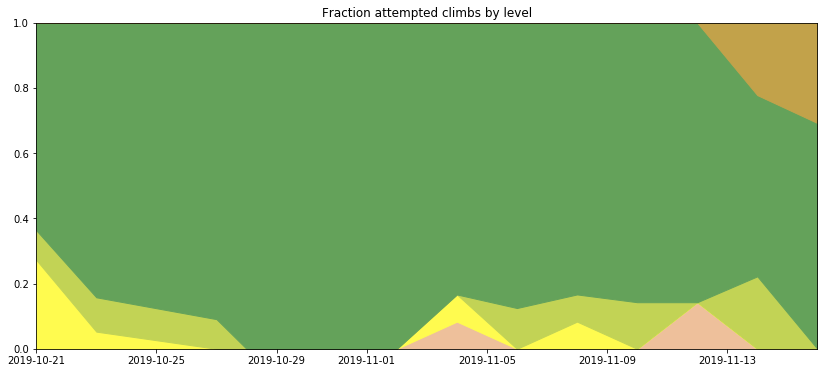

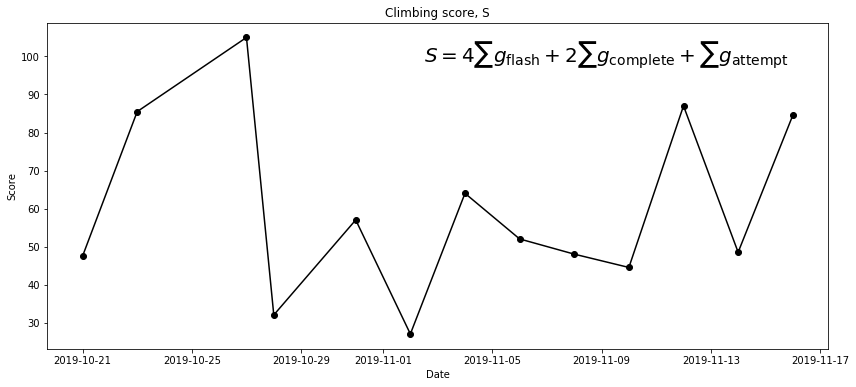

In [520]:
urllib.request.urlretrieve("http://kylemills.ca/climbing/dump.php?u=kmills&report_id=1&y=6", '/tmp/out.txt')
df = pd.read_csv("/tmp/out.txt")
df['date']= pd.to_datetime(df['date']) 
 
success_ratio(df)
plot_cum_frac(df, attempt=0)
plot_cum_frac(df, attempt=1)
climbing_score(df)

/home/kmills/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


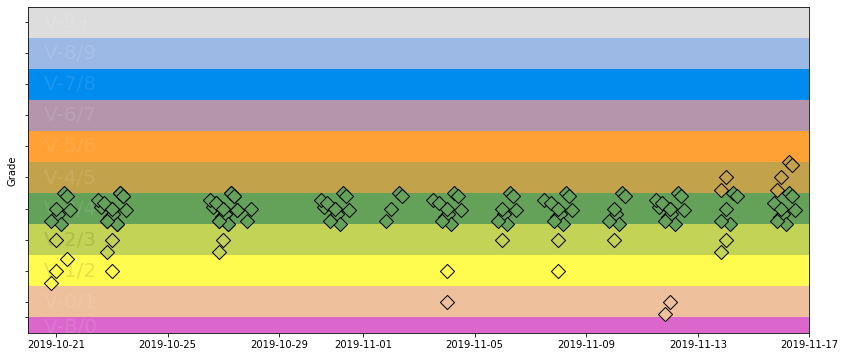

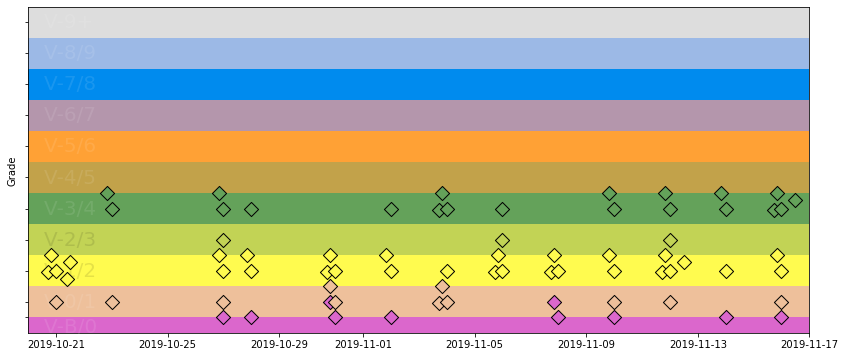

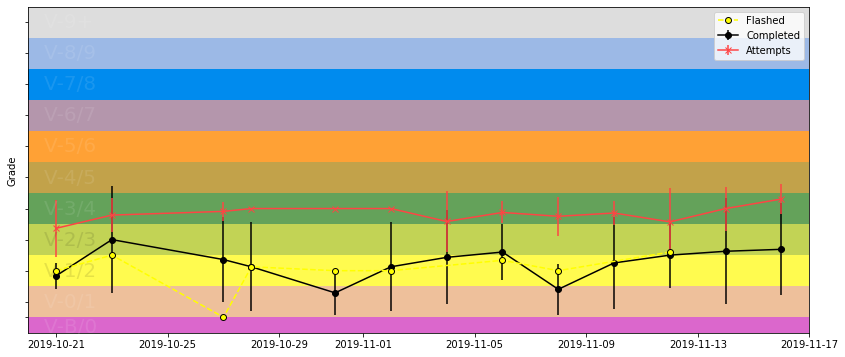

In [504]:
urllib.request.urlretrieve("http://kylemills.ca/climbing/dump.php?u=kmills", '/tmp/out.txt')
df = pd.read_csv("/tmp/out.txt")
df['date']= pd.to_datetime(df['date']) 

scatterplotclimbs(df, attempt=1)
scatterplotclimbs(df, attempt=0)
climbing_trends(df)
    